# Assingment 1 - MRI Contrast Classifier
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis


Welcome to the first course assignments! We have collected a dataset based on the popular BraTS challenge (http://braintumorsegmentation.org/), containing MRI slices of the brain, of different contrasts (sometimes referred to as modalities): T1-weighted (T1w), T1-weighted with contrast agent (T1w-CE), T2-weighted (T2w), and FLAIR, also a manually segmented binary map of a tumor, if visible on the slice. 

The assignments will build on each other, and all three of them will use the same dataset and the same data generator so take your time to familiarize yourself with these.

In the first assignments you are tasked with training a convolutional neural network to classify the acquired MR data into their contrasts (T1w, T1w-CE, T2w, FLAIR).

The code below is a working, but poor implementation of classifying between T1w and T2w contrasts. Your exercise is to expand and improve the code so the final model handles all four contrasts, and achieves an accuracy of $95\%$. 

The most important aspect of the assignment is that all your choices in the final code are explained and supported in writing. Show your though process, even if you have managed to improve the accuracy by trial and error. Make sure that in the report you include:
- How you reached the required performances
- Plot the confusion matrix of the validation data, using the final model.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the current setup, and how to solve them.

Upload the updated notebook to Canvas before February $16^{th}$, 15:00.

Good luck and have fun!

## Environment setup
conda create --name 3ra023vt23 python=3.8.12
- You now have an environment named “3ra023vt23”. Activate by:
$ conda activate 3ra023vt23
% Blank row

- Install CUDA and cuDNN:
conda install cudatoolkit=10.1.243 cudnn=7.6.5
- Install Tensorflow **with GPU** support:
conda install tensorflow-gpu=2.2.0
- Or, install Tensorflow **without GPU** support:
conda install tensorflow=2.2.0
- Install the other packages we need:
conda install jupyter=1.0.0
conda install matplotlib=3.5.0
conda install scikit-learn=1.0.2
conda install scikit-image=0.18.3

In [1]:
import os
import numpy as np
np.random.seed(2023)  # Set seed for reproducibility
import tensorflow as tf
tf.random.set_seed(2026)
!pip install tqdm # Adding tqdm to use progress bars. Unbarable waiting for each epoch to finish without feedback.
from tqdm import tqdm

Defaulting to user installation because normal site-packages is not writeable


In [36]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


##### The cell below will define the data generator for the data you will be using. You should not change anything in the below code!

In [3]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    arrays[idx][i, ] = x

        return arrays

# NOTE: Don't change the data generator!

In [4]:
gen_dir = "/import/software/3ra023/vt23/brats/data/"  # Change if you have copied the data locally on your machine
array_labels = ['t1', 't1ce', 't2', 'flair']  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.
N_CLASSES = len(array_labels)
batch_size = 32

gen_train = DataGenerator(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + 'validating',
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + 'testing',
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? Their order will be the same as their unpacking order during training!
# NOTE: What batch size are you using? Should you use more? Or less?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

### Let's plot some example images from the dataset:

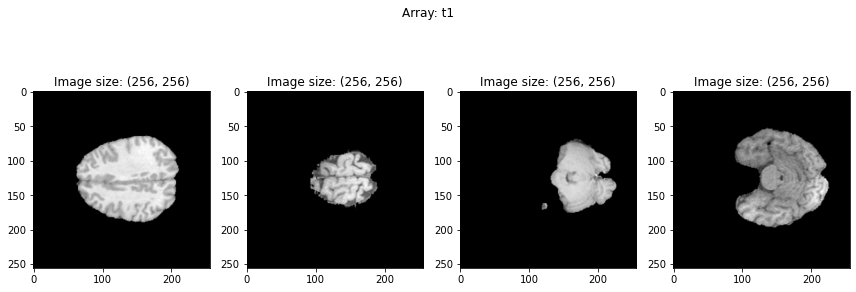

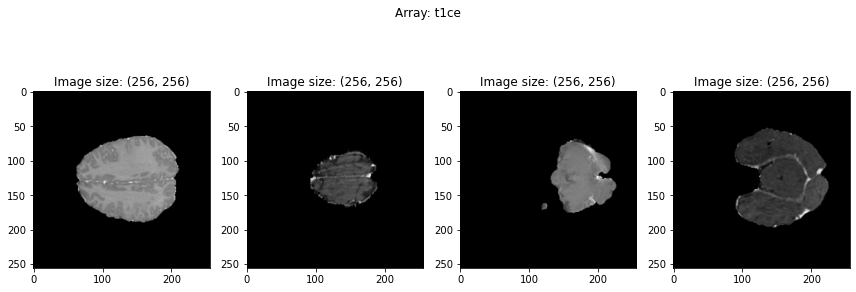

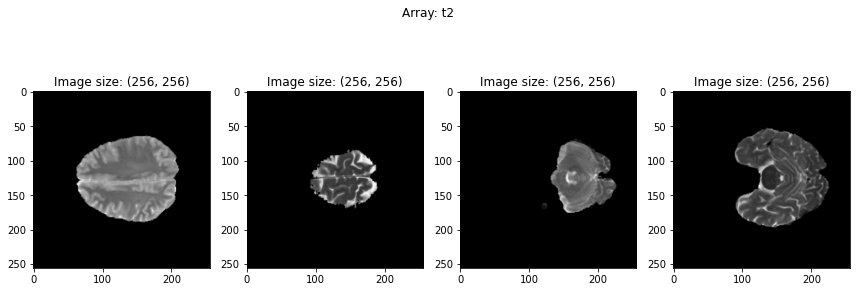

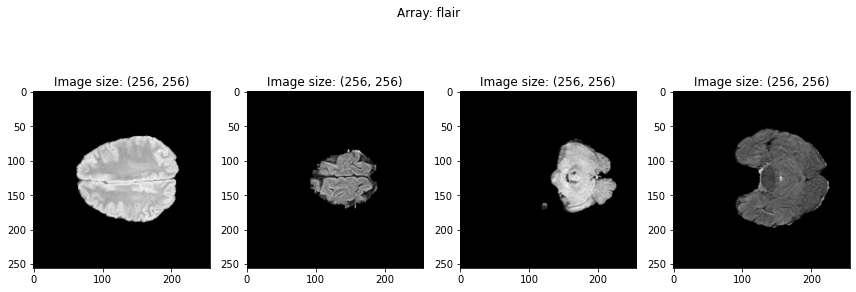

In [5]:
imgs = gen_train[0]
for inp in range(np.shape(imgs)[0]):
    plt.figure(figsize=(12,5))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(imgs[inp][i, :, :, 0], cmap='gray')
        plt.title('Image size: ' + str(np.shape(imgs[inp][i, :, :, 0])))
        plt.tight_layout()
    plt.suptitle('Array: ' + gen_train.arrays[inp])
    plt.show()

### The dataset preprocessing so far has been to help you, you should not change anything above. However, from now on, take nothing for granted.

A quick summery of the data sizes:

In [6]:
# A quick summary of the data:
print(f"Number of training images: {str(len(gen_train.file_list))}")
print(f"Training batch size      : {str(gen_train.in_dims)}")

Number of training images: 8000
Training batch size      : [(4, 256, 256, 1), (4, 256, 256, 1), (4, 256, 256, 1), (4, 256, 256, 1)]


In [7]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

# NOTE: Take inspiration from the imported layers and components, however you are not required to use all of them.

In [8]:
def build_model(height, width, channels):
    inp = Input(shape=(height, width, channels), name='input_1')
    drop_rate = 0.1 # 0.1 Small dropout throught the network.
    conv1 = Conv2D(8, 3, activation="relu", padding='same', kernel_initializer='he_normal',use_bias=False)(inp)
    #conv1 = BatchNormalization()(conv1) # During the first Training runs I had BN but worked without. 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(drop_rate)(pool1)

    conv2 = Conv2D(8, 3, activation="relu", padding='same', kernel_initializer='he_normal',use_bias=False)(pool1)
    #conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(16, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(drop_rate)(pool3)
    
    conv4 = Conv2D(32, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(drop_rate)(pool4)
    
    conv5 = Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_normal',use_bias=False)(pool4)
    #conv5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    pool5 = Dropout(drop_rate)(pool5)

    conv6 = Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_normal')(pool5)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    # Output layer to produce probabilities.
    flat = Flatten()(pool6)
    x = Dense(64, activation='relu')(flat)
    output_1 = Dense(4, activation='softmax')(x)

    return Model(inputs=[inp], outputs=[output_1])

# NOTE: A better designed network will improve performance. Look at the imported layers in the cell above for inspiration.

In [19]:
height, width, channels = gen_train.in_dims[0][1:]
model = build_model(height=height, width=width, channels=channels)
#model = build_resnet(height=height, width=width, channels=channels)

#model = build_improved_model()
model.summary()

# NOTE: Are the input sizes correct?
# NOTE: Are the output sizes correct?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are the model parameters split "evenly" between the layers? Or is there one huge layer?
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 8)       72        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 8)       576       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        1168

In [10]:
def load_model(path):
    m = keras.models.load_model(path)
    print(m.summary())
    return m

In [25]:
custom_lr = 0.001 # 0.00005, Original.  OTE: I used 0.0005 for the first 50 Epochs.
                  # It was then set to 0.0001 while finetuning.
weight_decay = 0.0 # No weight decay initialy. Increased to 0.02 to finetune.
custom_optimizer = Adam(lr=custom_lr,decay=weight_decay) # Replaced RMSprop for Adam.
custom_loss = "categorical_crossentropy" # MSE i used for regression. We'd like to predict categorically.
custom_metric = "accuracy"
#path = "./models/Axtorp_finetuned"
#model = load_model(path) # When used when finetuning the model.
model.compile(loss=custom_loss,
              optimizer=custom_optimizer,
              metrics=[custom_metric])
name = "test"
n_epochs = 1
n_classes = N_CLASSES
# Labels:
t1_label = tf.one_hot(np.repeat(0, batch_size), n_classes)
t1ce_label = tf.one_hot(np.repeat(1, batch_size), n_classes)
t2_label = tf.one_hot(np.repeat(2, batch_size), n_classes)
flair_label = tf.one_hot(np.repeat(3, batch_size), n_classes)

# NOTE: Are you satisfied with the loss function?
# NOTE: Are you satisfied with the metric?
# NOTE: Are you satisfied with the optimizer? Look at the cell where the optimizers are imported for inspiration.
# NOTE: Are you satisfied with the optimizer's parameters?

# How the model was designed.
# 1. The architecture was inspired by classical encoder backbones.
# 2. I started by training an unregularized model to overfit the data.

# Model Design.
I wanted to keep the model as small as possible while achiving the required accuracy of $95\%$. This was done by increasing the **depth** while keeping the output **MLP as small as possible** since it gives arise a large amount of complexity.
### Inspiration
The model was inspired by a simple encoder backbone with a feature extracting CNN reducing dimensionality before a final Multi Layer Perceptron concluded with a softmax activation to produce probability outputs. The CNN extracts important features from the images and summarizes the images in a feature vector which is passed to the output layer.
### Design proces

1. Overfit the data using a complex unregularized model with a large amount of filters per layer.
2. Reduce the complexity by decreasing the amount of filters while retaining depth.
3. When the variance of the model decreases. Slowly increase regularization to find a balance between complexity and variance.
Initialy the model included roughyl 900k parameters with a similar architecture as the final product only with more filters per convolutional layer and a deeper MLP as output.
The model size was quickly reduced upon iteration seeing as the model would quickly overfit the dataset at this size and depth. At first the model included BatchNormalization layer. These were later removed as the did not make a large difference. This should probably be reassed as the model without normalization layers probably induce large amount of variance throught the layers.

When the model size had been reduced it was necessary to include **Dropout** to regularize the model while retaining a high accuracy. This was done by including several dropout layers throughout the layers to make the layers more robust and less fixated on certain pixel values or activations.



## Metrics
The only metric used was the accuracy since the task stated that it was the sought after metric.
It could be useful to look at other metrics such as recall, precision and f1-score to get an idea of how the data/data augmentation should be altered. However since we only focus model creation part during this assignment, I deemed it not to be necessary.
## Loss function
I used **Categorical Crossentropy Loss** as a loss function. This is one of the most common loss functions used for classification and works intuitively well with a **Softmax** activation in the final output layer.

## Training procees.

When training the larger models as described under **Design Process** the learning rate set to $0.001$. I then tracked the training vs validation accuracy to see if the model would quickly overfit or if it the metrics properties would converge simultaneously. When achieving a relativly high accuracy on the validation set along a plateaued training loss value I decreased the learning rate to $0.0001$ and increased weight decay to $0.02$.

# Results
## Accuracy

| Data       | Accuracy (%) |
|------------|--------------|
| Train:     | 99.579       |
| Validation:| 96.312       |
| Test:      | 96.020       |

As seen in the table there is still a destinct difference between training accuracy and test accuracy. This should be addressed to further increase the test-set performance and improve the generalizability of the model.

## Improvements
### Training improvements
The results above could be improved by further increasing regularization terms such as Dropout, weight decay or implementing data augmentation. It could also be beneficial to implement a learning rate scheduler to vary the learning rate adaptively.
### Model improvements
The performance of the model could also be improved by adding skip-connections which has shown to be effective in classification tasks as seen in **ResNet** architectures widley used in classification. 

In [33]:
best = 0
batches = len(gen_train)
# Training Scheme
h = [1000,0] # Initial loss for progress bar.
for epoch in range(n_epochs):
    training_loss = [] # Track loss per epoch.
    validating_loss = []
    pbar = tqdm(enumerate(gen_train)) # Progess bar to make it less boring, and trackable.
    # Training data
    for idx, (t1, t1ce,t2,flair) in pbar:
        if (idx+1)%10==0:
            pbar.set_description(f"Training Epoch {epoch+1}/{n_epochs}. {idx+1}/{batches} Batch. Training Loss: {h[0]:.3e}, Accuracy: {h[1]:.3e}")
        labels = np.concatenate((t1_label,t1ce_label,t2_label, flair_label), axis=0)
        images = np.concatenate((t1, t1ce, t2, flair), axis=0)
        h = model.train_on_batch(images, labels)
        training_loss.append(h)
        
    train_vals = np.array(training_loss) # Convert to numpy for faster computation.
    ave_train_loss = train_vals[:,0].mean() # Get average loss and accuracy over the epoch.
    ave_train_acc =  train_vals[:,1].mean()
    pbar.set_description(f"Training Epoch {epoch+1}/{n_epochs}. {idx+1}/{len(gen_train)} Batches. Training Loss: {ave_train_loss:.3e}, Accuracy: {ave_train_acc:.3e}")
    # Validation data
    for idx, (t1, t1ce,t2,flair) in enumerate(gen_val):
        images = np.concatenate((t1, t1ce, t2, flair), axis=0)
        validating_loss.append(model.test_on_batch(images, labels)[-1])
    if np.mean(validating_loss)>best and best > 0.8:
        model.save("models/"+name)
            
    print(f"Epoch: {epoch + 1:2d}. Average accuracy - Training: {ave_train_acc:.3e}, Validation: {np.mean(validating_loss):.3e}")

Training Epoch 1/1. 2000/2000 Batch. Training Loss: 1.793e-01, Accuracy: 9.375e-01: : 2000it [01:48, 18.45it/s]


Epoch:  1. Average accuracy - Training: 8.491e-01, Validation: 8.512e-01


Code cell above demonstrates the training process with a progress bar.

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
def mean_average_accuracy(cm):
    return np.diag(cm).mean()
# Confusion matrix without using sklearn package.
def confusion_matrix(model,gen_data, name="",break_point:int=None):
    # Track predictions vs labels.
    #preds = []
    #ls = []
    cm = np.zeros((4,4)) # Initialize the confusion matrix.
    labels = np.concatenate((t1_label,t1ce_label,t2_label, flair_label), axis=0) # Create batched label.
    for idx, (t1, t1ce,t2,flair) in enumerate(gen_data):
        images = np.concatenate((t1, t1ce, t2, flair), axis=0) # Batch images.
        #ls.append(labels.argmax(1).flatten()) # Add the seen labels to track metrics.
        pred = model.predict_on_batch(images).argmax(1)
        #preds.append(pred.flatten())
        for l,p in zip(labels.argmax(1),pred):
            cm[l,p] += 1 # Count number of guesses per class.
        if break_point and idx>=break_point-1:
            break
    cm = cm/cm.sum(0) # Normalize along prediced channel.
    #result = confusion_matrix(np.array(ls).flatten(), np.array(preds).flatten() , normalize='pred')
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = array_labels)
    cm_display.plot()
    cm_display.im_.figure.suptitle(name)
    plt.plot()
    print(f"Accuracy - {name}: {np.diag(cm).mean()*100:.3f}%")
    return cm


Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_352 (Conv2D)          (None, 256, 256, 8)       72        
_________________________________________________________________
max_pooling2d_314 (MaxPoolin (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_204 (Dropout)        (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_353 (Conv2D)          (None, 128, 128, 8)       576       
_________________________________________________________________
max_pooling2d_315 (MaxPoolin (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_354 (Conv2D)          (None, 64, 64, 16)        116

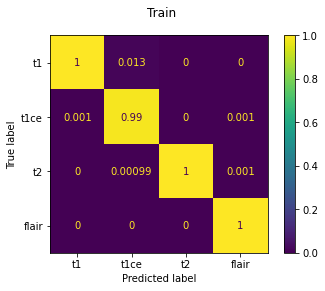

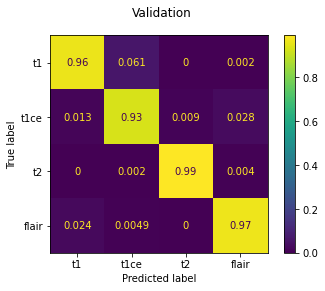

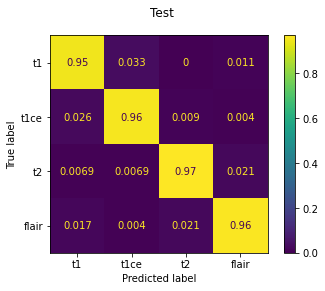

In [35]:
def test_model(model):
    train_preds,train_labels,cm_train,cm_disp_train = confusion_matrix(model,gen_train,"Train",len(gen_val))
    val_preds,val_labels,cm_val,cm_disp_val = confusion_matrix(model,gen_val,"Validation")
    test_preds,test_labels,cm_test,cm_disp_test = confusion_matrix(model,gen_test,"Test")
def load_model(path):
    m = keras.models.load_model(path)
    print(m.summary())
    return m
final_model = load_model("models/Axtorp_finetuned")
test_model(final_model)
